In [ ]:
#!pip install --upgrade gensim

In [1]:
# imports
import pandas as pd
import numpy as np
from google.cloud import storage
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
import gensim.downloader as api

%matplotlib inline

In [2]:
# Get files from GCS bucket
BUCKET_NAME = 'salary-data'
client = storage.Client()
bucket = client.get_bucket(BUCKET_NAME)

blobs = bucket.list_blobs()
files = []
for blob in blobs:
    files.append(blob.name)
    
print(files)

['2011_Travel_to_Work_Areas_summary_statistics_V5.csv', 'Location_Tree.csv', 'Test_rev1.csv', 'Train_rev1.csv', 'Valid_rev1.csv', 'X_test_padded', 'X_train_padded', 'X_val_padded', 'data_location_buckets.csv', 'mean_benchmark.csv', 'random_forest_benchmark_test_rev1.csv', 'test.csv', 'vocab_size', 'y_test', 'y_train', 'y_val']


In [32]:
# Read data
df_TTWA = pd.read_csv('gs://{}/{}'.format(BUCKET_NAME,files[0]))
df_train = pd.read_csv('gs://{}/{}'.format(BUCKET_NAME,files[3]))

In [ ]:
from functions_6 import TTWA_county_feature
df_loc = TTWA_county_feature(df_train,df_TTWA,True) 


In [ ]:
TTWA_county = df_loc.TTWA_County
df_all = pd.concat([df_train, TTWA_county], axis = 1)
df_all

In [ ]:
client = storage.Client()
bucket = client.get_bucket(BUCKET_NAME)
bucket.blob('data_location_buckets.csv').upload_from_string(df_all.to_csv(), 'text/csv')

## Deal with NaN values

In [33]:
# Fill in missing values for Contract and Company
df_all =df_train
df_all.ContractType = df_train.ContractType.fillna('Missing')
df_all.ContractTime = df_train.ContractTime.fillna('Missing')
df_all.Company = df_train.Company.fillna('Missing')
# Drop other NaN values
df_all = df_all.dropna()
df_all.isnull().sum()

Id                    0
Title                 0
FullDescription       0
LocationRaw           0
LocationNormalized    0
ContractType          0
ContractTime          0
Company               0
Category              0
SalaryRaw             0
SalaryNormalized      0
SourceName            0
dtype: int64

## NLP of Description

In [34]:
import functions_12 as fn
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split

In [35]:
df_train = df_all

In [36]:
def first_NLP(df):
    word_list = []
    for index, row in df.iterrows():
        bag = row.FullDescription
        ns = fn.remove_stop_words(bag, unique = False)
        lemma = fn.lemmatize_words(ns)
        word_list.append(lemma)
    return word_list

In [37]:
# Create a train, val, test split

X_train_full, X_test, y_train_full, y_test = train_test_split(
                                df_train.drop(['SalaryNormalized','SalaryRaw'], axis =1),
                                df_train.SalaryNormalized, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
                                                X_train_full,
                                                y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Remove grammer, capitals, and stop words
X_train_words = first_NLP(X_train)
X_val_words = first_NLP(X_val)
X_test_words = first_NLP(X_test)

In [ ]:
# create dictionary of only the TRAIN text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_words)
word_dictionary = tokenizer.word_index
size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding

In [ ]:
# Convert text to indexed list
X_train_seq = tokenizer.texts_to_sequences(X_train_words)
X_val_seq = tokenizer.texts_to_sequences(X_val_words)
X_test_seq = tokenizer.texts_to_sequences(X_test_words)

In [ ]:
# Pad sequences

max_length = fn.get_max_length(X_train_seq, X_test_seq, X_val_seq)

X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq,maxlen=max_length, padding='post')
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq,maxlen=max_length, padding='post')
X_val_padded = tf.keras.preprocessing.sequence.pad_sequences(X_val_seq,maxlen=max_length, padding='post')

## Save/ Load data

In [3]:
import json
# data = tokenizer.word_index
file = './word_index.json' 
# with open(file, 'w') as f:  
#     json.dump(data, f)

with open(file) as f:
    word_index = json.load(f)

In [4]:
# df_X_train =  pd.DataFrame(X_train_padded)
# df_X_test = pd.DataFrame(X_test_padded)
# df_X_val = pd.DataFrame(X_val_padded)
# df_size_vocab = pd.DataFrame([size_of_vocabulary])

# bucket.blob('X_train_padded').upload_from_string(df_X_train.to_csv())
# bucket.blob('X_test_padded').upload_from_string(df_X_test.to_csv())
# bucket.blob('X_val_padded').upload_from_string(df_X_val.to_csv())
# bucket.blob('vocab_size').upload_from_string(df_size_vocab.to_csv())
# bucket.blob('y_train').upload_from_string(y_train.to_csv())
# bucket.blob('y_test').upload_from_string(y_test.to_csv())
# bucket.blob('y_val').upload_from_string(y_val.to_csv())

df_X_train = pd.read_csv('gs://{}/{}'.format(BUCKET_NAME,'X_train_padded'))
df_X_test = pd.read_csv('gs://{}/{}'.format(BUCKET_NAME,'X_test_padded'))
df_X_val = pd.read_csv('gs://{}/{}'.format(BUCKET_NAME,'X_val_padded'))
df_size_vocab = pd.read_csv('gs://{}/{}'.format(BUCKET_NAME,'vocab_size'))
y_train = pd.read_csv('gs://{}/{}'.format(BUCKET_NAME,'y_train'))
y_test = pd.read_csv('gs://{}/{}'.format(BUCKET_NAME,'y_test'))
y_val = pd.read_csv('gs://{}/{}'.format(BUCKET_NAME,'y_val'))

X_train_padded = df_X_train.to_numpy()[:,1:]
X_test_padded = df_X_test.to_numpy()[:,1:]
X_val_padded = df_X_val.to_numpy()[:,1:]
size_of_vocabulary = df_size_vocab.to_numpy()[0][1]
max_length = X_train_padded.shape[1]

In [5]:
y_train = pd.read_csv('gs://{}/{}'.format(BUCKET_NAME,'y_train'))
y_test = pd.read_csv('gs://{}/{}'.format(BUCKET_NAME,'y_test'))
y_val = pd.read_csv('gs://{}/{}'.format(BUCKET_NAME,'y_val'))

y_train = y_train['SalaryNormalized'].values
y_test = y_test['SalaryNormalized'].values
y_val = y_val['SalaryNormalized'].values

## Load the GloVe embeddings and make a dictionary

In [6]:
# Load word embeddings from GloVe
glove_model = api.load('glove-twitter-25')

In [7]:
embeddings_index = dict()
glove_dict = glove_model.vocab

for key, value in glove_dict.items():
    word = key
    coef = glove_model[key]
    embeddings_index[word] = coef

In [ ]:
# print(glove_model.vectors[value.index]) 
# print(glove_model[key]) # array
# print(key)# word
# print(value.index) # 
# print(embeddings_index['i'])
# print(glove_model['i'])

In [8]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((size_of_vocabulary, 25))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Make data-set smaller

In [164]:
# Make data set smaller
ratio = 10
X_train_small = X_train_padded[0:X_train_padded.shape[0]//ratio,:]
y_train_small = y_train[0:y_train.shape[0]//ratio]
X_test_small = X_test_padded[0:X_test_padded.shape[0]//ratio,:]
y_test_small = y_test[0:y_test.shape[0]//ratio]
X_val_small = X_val_padded[0:X_val_padded.shape[0]//ratio,:]
y_val_small = y_val[0:y_val.shape[0]//ratio]

# Check shapes are the same
print(X_train_small.shape[0] == y_train_small.shape[0])
print(X_test_small.shape[0] == y_test_small.shape[0])
print(X_val_small.shape[0] == y_val_small.shape[0])

True
True
True


## Create model

In [125]:
from tensorflow import keras
import tensorflow as tf
from keras import layers
from keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [162]:
#batch_size  = 32

model = Sequential()
model.add(layers.Embedding(size_of_vocabulary, 25, weights=[embedding_matrix], input_length=max_length, trainable=False))

model.add(Conv1D(filters=100, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(layers.Flatten())

model.add(layers.Dense(10, activation = 'relu'))
#model.add(layers.Dense(10, activation = 'relu'))

model.add(layers.Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())



Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 1267, 25)          3742725   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1263, 100)         12600     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 631, 100)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 63100)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                631010    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
Total params: 4,386,346
Trainable params: 643,621
Non-trainable params: 3,742,725
_____________________________________

## Train model 

In [163]:
# fit the model
epochs = 10
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train_small, y_train_small, epochs=epochs, verbose=1,
         validation_data=(X_val_small, y_val_small), callbacks = es)

Epoch 1/10
490/490 [==============================] - 76s 155ms/step - loss: 551649344.0000 - val_loss: 306588288.0000
Epoch 2/10
490/490 [==============================] - 74s 150ms/step - loss: 297615584.0000 - val_loss: 285374336.0000
Epoch 3/10
490/490 [==============================] - 76s 155ms/step - loss: 280243168.0000 - val_loss: 274368928.0000
Epoch 4/10
490/490 [==============================] - 72s 147ms/step - loss: 270828864.0000 - val_loss: 268242208.0000
Epoch 5/10
490/490 [==============================] - 74s 151ms/step - loss: 264664160.0000 - val_loss: 264180624.0000
Epoch 6/10
490/490 [==============================] - 75s 154ms/step - loss: 260246960.0000 - val_loss: 261714160.0000
Epoch 7/10
490/490 [==============================] - 75s 153ms/step - loss: 256518272.0000 - val_loss: 258676656.0000
Epoch 8/10
490/490 [==============================] - 76s 156ms/step - loss: 254078032.0000 - val_loss: 257147280.0000
Epoch 9/10
490/490 [============================

## Evaluate model 

In [165]:
# evaluate the model
loss = model.evaluate(X_test_small, y_test_small, verbose=1)
print('MSE: {}'.format(loss))
print('RMSE: {}'.format(np.sqrt(loss)))
# Save RMSEs of different models
#save_rmse = [] 
save_rmse.append(np.round(np.sqrt(loss)))

153/153 [==============================] - 10s 66ms/step - loss: 252522544.0000
MSE: 252522544.0
RMSE: 15890.957932107176


In [167]:
# Check the RMSE when the y_pred is just the mean value of the salary
y_mean = np.mean(y_train_small)
rmse_mean = np.sqrt(np.mean((y_test_small-y_mean)**2))
save_rmse[4] = rmse_mean
# save_rmse.append(rmse_mean)

In [168]:

dict_rmse = {"CNN_128_filters":save_rmse[0]
              ,"No_HL":save_rmse[1]
              ,"1_HL":save_rmse[2]
              ,"2_HL":save_rmse[3]
              ,"mean":save_rmse[4]
              ,"CNN_100_1HL":save_rmse[5]
            }
print(dict_rmse)

{'CNN_128_filters': 16035.0, 'No_HL': 32668.0, '1_HL': 17582.0, '2_HL': 17156.0, 'mean': 17773.193646460542, 'CNN_100_1HL': 15891.0}


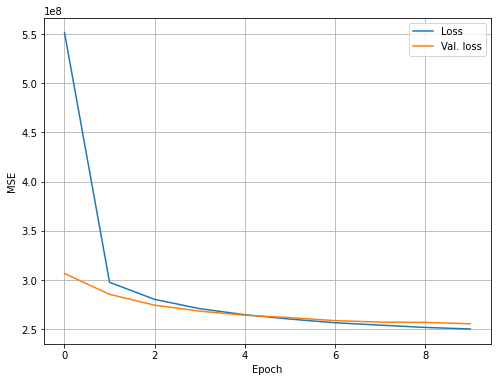

In [169]:
fig = plt.figure(figsize = (8,6))  
ax = fig.add_subplot(1, 1, 1)  
ax.plot(range(epochs), history.history['loss'], label = 'Loss')
ax.plot(range(epochs), history.history['val_loss'], label = 'Val. loss')
ax.legend()
ax.set_ylabel('MSE')
ax.set_xlabel('Epoch')
# ax.set_xlim(limits)
# ax.set_ylim(limits)
plt.grid()
plt.show()

## Prediction

In [170]:
y_predict = model.predict(X_test_small, verbose = 1)

153/153 [==============================] - 10s 66ms/step


In [184]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(y_test_small.reshape(-1, 1), y_predict.reshape(-1, 1))
print(reg.score(y_test_small.reshape(-1, 1), y_predict.reshape(-1, 1)))
lin_reg = reg.predict(y_test_small.reshape(-1,1))


0.20595037570517327


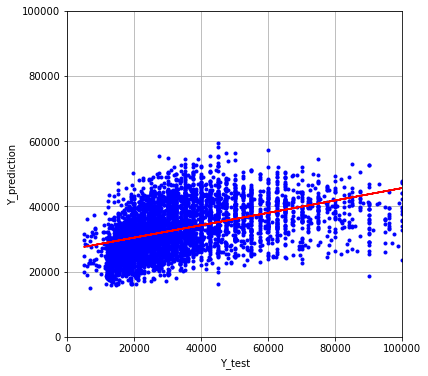

In [182]:
limits= [0,100000]
fig = plt.figure(figsize = (6,6))  
ax = fig.add_subplot(1, 1, 1)  
ax.plot(y_test_small, y_predict, 'b.')
ax.plot(y_test_small,lin_reg,'r')
ax.set_ylabel('Y_prediction')
ax.set_xlabel('Y_test')
ax.set_xlim(limits)
ax.set_ylim(limits)
plt.grid()
plt.show()